<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template and tests for an LSTM Auto-Encoder


In [1]:
import tensorflow as tf


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.__version__

'2.3.1'

In [4]:
from astropy.cosmology import Planck18_arXiv_v2 as cosmo

In [5]:
import tensorflow_datasets as tfds

In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [7]:
# ! pip install tensorflow-probability==0.11.0
# ! pip install --user -e /global/homes/v/vboehm/codes/SDSS_PAE/    

In [8]:
import tensorflow_probability as tfp

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Layer, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, UpSampling1D, AveragePooling1D
from tensorflow.keras.layers import RepeatVector, Conv2DTranspose, Flatten
from tensorflow.keras.layers import TimeDistributed, Input, Lambda, Masking, Dropout
import tensorflow.keras.backend as K

In [10]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='valid', output_padding=0, name=None):
    """
        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding, output_padding=(output_padding,0), name=name)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

#### load some SDSS data


In [12]:
import sdss_pae.sdss_dataset as sdss 

In [12]:
ds, info = tfds.load('SDSS', data_dir='/global/cscratch1/sd/vboehm/Datasets/SDSS_BOSS_data_large',with_info=True, split='train')

In [13]:
info

tfds.core.DatasetInfo(
    name='sdss',
    version=1.0.0,
    description='selected features from spAll and spZbest files 
'flux': measured spectrum in  
'inv_var': inverse variance
'and_mask': and mask (set to 1 for all non-zero entries)
'coeffs': c0, c1, npix. calculate wavelengths with `10.**(c0 + c1 * np.arange(npix))`
'label': type of object, 'STAR'==0, 'QSO'==1, 'GALAXY'==2
'redshift': object redshift estimate',
    homepage='https://www.sdss.org/science/data-release-publications/',
    features=FeaturesDict({
        'and_mask': Tensor(shape=(None, 1), dtype=tf.int32),
        'coeffs': Tensor(shape=(3, 1), dtype=tf.float32),
        'filename': Text(shape=(), dtype=tf.string),
        'flux': Tensor(shape=(None, 1), dtype=tf.float32),
        'inv_var': Tensor(shape=(None, 1), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
        'redshift': tf.float32,
    }),
    total_num_examples=500000,
    splits={
        'train': 500000,
    }

In [14]:
# use only galxies for now
select_by   = 2
# de-redhsift or not?
de_redshift = True

In [15]:
z_ref  = 0.1
ld_ref = cosmo.luminosity_distance(z_ref)

In [16]:
# filter dataset by redshifts and type

def filter_type_fn(x):
    if select_by is not None:
        return tf.math.equal(x['label'], select_by)
    else: return 1
    
def filter_redshift_fn(x):
    if select_by is not None:
        return tf.math.greater(x['redshift'], 0.001)
    else: return 1

ds = ds.filter(filter_type_fn)
ds = ds.filter(filter_redshift_fn)

In [17]:
DATASET_SIZE=len(list(ds))

In [18]:
print('size of subselected data:', DATASET_SIZE)

size of subselected data: 286193


In [19]:
# computing maximum and minimum redhsift in the data sample, getting distribution of data sizes
# this doe not need to be run every time - especially if wavelength range is set by user

ii          = 0
min_wl      = 100
max_wl      = -100
num_npixs   = []
img_coeffs1 = []
img_coeffs2 = []
factors     = []
min_z       = 5
max_z       = -5
redshifts   = []

for image in tfds.as_numpy(ds):
    log10wl = image['coeffs'][0][0] + image['coeffs'][1][0] * np.arange(image['coeffs'][2][0])
    if de_redshift:
        log10wl = log10wl-np.log10(1+image['redshift'])
    if max(log10wl)>max_wl:
        max_wl= max(log10wl)
    if min(log10wl)<min_wl:
        min_wl=min(log10wl)
    redshifts.append(image['redshift'])
#     if image['redshift']>max_z:
#         max_z = image['redshift']
#     if image['redshift']<min_z:
#         min_z = image['redshift']
#     if image['coeffs'][2] not in num_npixs:
#         num_npixs.append(image['coeffs'][2][0])
#         img_coeffs1.append(image['coeffs'][1][0])
#     if image['coeffs'][0] not in img_coeffs2:
#         img_coeffs2.append(image['coeffs'][0][0])
#     if ii<10:
#         print(image['redshift'], image['label'],image['redshift'])
#         factor = (cosmo.luminosity_distance(image['redshift'])/ld_ref)**2
#         plt.plot(10**log10wl,image['flux'][:,0]*10**log10wl*factor)
#         plt.show()
#         ii+=1
     
wl_range = (min_wl, max_wl) 

np.save('wl_range_galaxies_only.npy',wl_range)

In [11]:
wl_range = np.load('wl_range_galaxies_only.npy')

In [12]:
min_wl, max_wl = wl_range

In [13]:
print(10**min_wl, 10**max_wl)

# compute number of pixels that span entire wl range:
npix_max = -(min_wl-max_wl)/np.unique(1e-4)
print(npix_max)

1193.424155505669 10392.874584190184
[9399.40862542]


In [14]:
### settings
# user defined span (following Yip et al and Portillo et al)
wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
latent_dim      = 20
network_type    = 'fully_connected'

In [15]:
wl_range      = (np.log10(wlmin),np.log10(wlmax))

In [19]:
from scipy.interpolate import interp1d

In [69]:
# new binning 

new_wl         = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

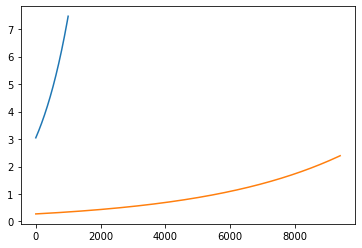

In [21]:
plt.plot(np.diff(new_wl))
plt.plot(np.diff(10**(min_wl+np.arange(npix_max)*1e-4)))

In [27]:
from scipy.stats import binned_statistic

In [28]:
raw_flux           = []
raw_noise          = []
raw_masks          = []

res_fluxes         = []
res_inv_vars       = []
res_masks          = []
redshifts          = []

SNs                = []

flag               = []

ii=0

for nn, image in enumerate(tfds.as_numpy(ds)):
        
    # compute wavelengths
    log10wl  = image['coeffs'][0][0] + image['coeffs'][1][0] * np.arange(image['coeffs'][2][0])
    log10wl  = log10wl
    wl       = 10**log10wl
    
    raw_flux.append(image['flux'])
    raw_noise.append(image['inv_var'])
    raw_masks.append(image['and_mask'])
    ##rescale flux by wavelength and distance
    factor   = (cosmo.luminosity_distance(image['redshift'])/ld_ref)**2
    #flux
    
    ### change that to before de-redshifting
    flux     = image['flux'][:,0]*factor*wl
    #inv_var
    inv_var  = image['inv_var'][:,0]/(wl*factor)**2
    
    wl/=(1.+image['redshift'])
    
    ## mask
    
    #mask
    mask           = np.squeeze(image['and_mask'])
    #mask pixels that are completely noise dominated (mask!)
    noise_         = np.squeeze(inv_var)
    ind            = np.where(noise_==0.)
    mask[ind]      = False 
    # additional mask on skylines
#     lines_wl       = (5565,5590)/(1+image['redshift'])
#     lines_ind      = np.digitize([lines_wl[0],lines_wl[1]],wl)
#     lines_ind      = np.arange(lines_ind[0],lines_ind[1])
#     mask[lines_ind]= False
    mask_ind = np.where(mask)

    if len(mask_ind[0])==0:
        continue
    ##resample
    #flux
    else:
        res_flux, _, _ = binned_statistic(wl[mask_ind], flux[mask_ind],bins=new_wl)
        

        #inv_var
#         interval       = np.digitize((new_wl[0],new_wl[-1]),wl)
#         #print(wl[interval[0]:interval[1]],new_wl[0],new_wl[-1])
#         N              = np.digitize(new_wl, wl[interval[0]:interval[1]])
#         N              = np.diff(N)
#         #make sure N=0 is only outside of boundaries where everything is set to zero anyways
#         assert(np.all(np.logical_or(new_wl[np.where(N==0)]<min(wl),new_wl[np.where(N==0)]>max(wl))))
#         N[np.where(N==0)]=1
#         N              = np.append(N,1)

    #     plt.figure()
    #     plt.plot(wl,noise_)
    #     plt.plot(wl[mask_ind],noise_[mask_ind])
    #     #plt.ylim(0,1)
    #     plt.show()


        noise          = 1./noise_[mask_ind]
        noise_, _, _   = binned_statistic(wl[mask_ind],noise,bins=new_wl)
        N, _, _        = binned_statistic(wl[mask_ind],values=np.zeros(len(wl[mask_ind])),statistic='count',bins=new_wl)
        new_mask_ind   = np.where(N==0)
        noise_          = noise_/N
        inv_var_res    = 1./noise_
        res_flux[new_mask_ind] = 0
        res_fluxes.append(res_flux)
    
#         #mask
#         # conservative
#         mask[np.where(wl<min(new_wl))]=0
#         mask[np.where(wl>max(new_wl))]=0


#         mask_ind      = np.unique(np.digitize(wl[interval[0]:interval[1]][np.where(np.logical_not(mask[interval[0]:interval[1]]))],new_wl))
#         #print(mask_ind)
        new_mask_cons = np.ones(len(new_wl)-1)
        new_mask_cons[new_mask_ind] = 0.
#         # set mask to zero outside of wl boundaries
#         new_mask_cons[np.where(new_wl<min(wl))]=0
#         new_mask_cons[np.where(new_wl>max(wl))]=0

# #         plt.plot(wl,mask)
# #         plt.plot(new_wl,new_mask_cons)
# #         plt.xlim(5000,5100)
# #         plt.show()

#         #flag is a good flag
            
        res_masks.append(new_mask_cons)
# len(np.where(new_mask_cons==0)[0])<fixed_num_bins*0.8 and 

#         SN = np.sum(res_flux)/np.sqrt(np.sum(1./inv_var_res))
#         SNs.append(SN)
        
#         inv_var_res[new_mask_ind] = 0
#         res_inv_vars.append(inv_var_res)
    
#         if SN<50:
#             flag.append(ii)

        redshifts.append(image['redshift'])
        ii+=1

In [34]:
np.save('/global/cscratch1/sd/vboehm/Datasets/SDSS_BOSS_preprocessed/galaxies_1000bins_min1e-3_wlrange_3388_8318.npy',[res_fluxes,res_inv_vars,res_masks,redshifts,SNs])

In [219]:
res_fluxes,res_inv_vars,res_masks,redshifts,SNs = np.load('/global/cscratch1/sd/vboehm/Datasets/SDSS_BOSS_preprocessed/galaxies_1000bins_min1e-3_wlrange_3388_8318.npy', allow_pickle=True)

In [220]:
res_fluxes=np.asarray(list(res_fluxes))

In [221]:
res_inv_vars=np.asarray(list(res_inv_vars))

res_masks=np.asarray(list(res_masks))
#,res_masks,redshifts,SNs

In [191]:
res_fluxes.shape

(286142, 1000)

In [192]:
import sklearn

In [193]:
from sklearn.decomposition import PCA as PCA

In [194]:
pca       = PCA(n_components=200)
pca.fit(res_fluxes)

variances = pca.explained_variance_ratio_


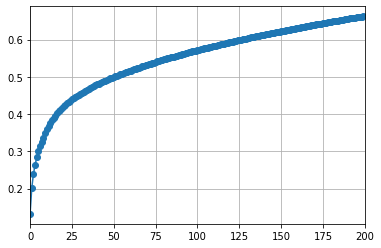

In [195]:
plt.plot(np.cumsum(variances),marker='o')
plt.xlim(-0.01,200)
plt.grid()

In [204]:
enc   = pca.transform(res_fluxes)
recon = pca.inverse_transform(enc)

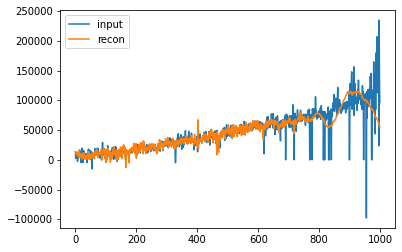

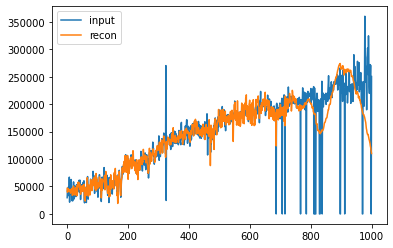

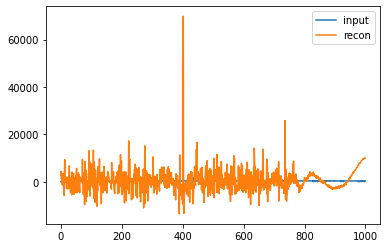

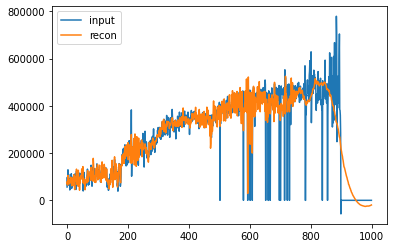

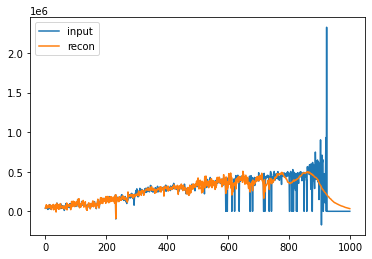

In [205]:
for ii in range(5):
    plt.plot(np.asarray(res_fluxes)[ii], label= 'input')
    plt.plot(recon[ii],label='recon')
    plt.legend()
    plt.show()

In [222]:

dim        = fixed_num_bins

In [223]:
from tensorflow.keras.layers import concatenate as concat

In [259]:
class bottleneck(Layer):
    def __init__(self, units, dim, **kwargs):
        self.units  = units
        self.dim    = dim
        self.LSTM1  = LSTM(units[0],  return_sequences=True)
        self.LSTM2  = LSTM(units[1],  return_sequences=False)
        self.Repeat = RepeatVector(dim)
        super(bottleneck, self).__init__(**kwargs)

    def call(self, inputs):
        return self.Repeat(self.LSTM2(self.LSTM1(inputs)))

    def compute_mask(self, inputs, mask=None):
        return mask


input        = Input(shape=(dim,1))
input_params = Input(shape=(1))
input_mask   = Input(shape=(dim,1))
input_noise  = Input(shape=(dim,1))


if network_type=='fully_connected':
# simplest, not many architectural choices other than number of neurons, likely to overfit
    #encoder_input = input#tf.concat([input,tf.tile(input_z,[tf.shape(input)[0],1])], axis=1)
#    x = Reshape((dim,))(input)
#    x = tf.concat([input,input_params],axis=1)
    x = Flatten()(input)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(32)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(latent_dim)(x)  
    #x = tf.concat([x,input_params],axis=1)
    #z = Flatten()(input_params)
    #x = tf.concat([input_params,x], axis=1)
    x = Dense(32)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Dense(dim)(x)
    x = Reshape((dim,1))(x)
elif network_type=='LSTM':
# slow training
    x = LSTM(256, return_sequences=True)(input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = LSTM(latent_dim,  return_sequences=False, name='bottleneck')(x)
    x = RepeatVector(dim)(x)
    x = LSTM(latent_dim, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = LSTM(256, return_sequences=True)(x)
    x = TimeDistributed(Dense(1))(x)
elif network_type=='CNN':
# better than fully connected, but more choices to make for architecture, performance might be very much dependent on architecture
    x = Conv1D(filters=64,kernel_size=(5), strides=2, name='conv1', padding='same')(input)
    x = BatchNormalization(name='bn1')(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2, name='maxpool1', padding='same')(x)
    x = Conv1D(filters=32,kernel_size=(3), strides=2,name='conv2', padding='same')(x)
    x = BatchNormalization(name='bn2')(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2,name='maxpool2', padding='same')(x)
    x = Conv1D(filters=32,kernel_size=(3), strides=2, name='conv3', padding='same')(x)
    x = BatchNormalization(name='bn3')(x)
    x = LeakyReLU()(x)
    x = Flatten()(x)
    #x = tf.concat([y,input_params],axis=1)
    x = Dense(latent_dim, name='fc_enc')(x)
    x = LeakyReLU()(x)
    #x = tf.concat([z,input_params], axis=1)
    x = Dense(1024,name='fc_dec')(x)
    x = LeakyReLU()(x)
    x = Reshape((32,32))(x)
    x = Conv1DTranspose(input_tensor=x,filters=32,kernel_size=(3),strides=2, name='conv1T', padding='same')
    x = BatchNormalization(name='bn1T')(x)
    x = LeakyReLU()(x)
    #x = UpSampling1D(2, name='up1')(x)
    x = Conv1DTranspose(input_tensor=x,filters=32,kernel_size=(3),strides=2, name='conv2T', padding='same')
    x = BatchNormalization(name='bn2T')(x)
    x = LeakyReLU()(x)
    x = UpSampling1D(2,name='up2')(x)
    x = Conv1DTranspose(input_tensor=x,filters=64,kernel_size=(5),strides=2, name='conv3T', padding='same')
    x = BatchNormalization(name='bn3T')(x)
    x = LeakyReLU()(x)
    x = Conv1DTranspose(input_tensor=x,filters=1,kernel_size=(1),strides=1, padding='same')
#    x = Reshape((dim,1))(x)
else:
    raise ValueError('Network type not supported')

def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = (tf.reduce_mean(loss*mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(input_data[0], training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}




    
    
    
lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_params], outputs=x)
lstm_ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), my_loss=lossFunction, metrics=[],run_eagerly=False)

# lstm_ae = Model(inputs=[input, input1,input2, input_float], outputs=[x, input1,input2, input_float])
# lstm_ae.compile(optimizer='adam', loss=lossFunction)
print(lstm_ae.summary())

Model: "custom_model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
flatten_11 (Flatten)            (None, 1000)         0           input_45[0][0]                   
__________________________________________________________________________________________________
dense_110 (Dense)               (None, 512)          512512      flatten_11[0][0]                 
__________________________________________________________________________________________________
batch_normalization_88 (BatchNo (None, 512)          2048        dense_110[0][0]                  
____________________________________________________________________________________

In [225]:
# for i, l in enumerate(lstm_ae.layers):
#     print(f'layer {i}: {l}')
#     print(f'has input mask: {l.input_mask}')
#     print(f'has output mask: {l.output_mask}')

In [226]:


# train_dataset = prep_data.take(train_size).repeat().map(lambda x: ((x['flux'],x['detrend'], x['mask'], x['inverse']),x['flux'])).batch(BATCH_SIZE)
# test_dataset  = prep_data.skip(train_size).take(test_size).map(lambda x: ((x['flux'],x['detrend'], x['mask'], x['inverse']),(x['flux'], x['mask'], x['inverse']))).batch(BATCH_SIZE)
# valid_dataset = prep_data.skip(train_size+test_size).take(valid_size).map(lambda x:((x['flux'],x['detrend'], x['mask'], x['inverse']),(x['flux'], x['mask'], x['inverse']))).batch(BATCH_SIZE)


In [227]:
min_z=0.1
max_z=0.4

In [228]:
def redshift_bin(min_z, max_z, z_array, arrays):
    num  = len(arrays)
    indx = np.where((redshifts>min_z)*(redshifts<max_z))[0]
    arrays_new = [arrays[ii][indx] for ii in range(num)]
    print('new datasize: ', len(indx))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts = redshift_bin(min_z, max_z, redshifts, [res_fluxes, res_masks, res_inv_vars, redshifts])

new datasize:  54731


In [229]:
DATASET_SIZE = len(res_fluxes)

In [230]:
SNs =[]
for ii in range(DATASET_SIZE):
    SNs.append(np.sum(res_fluxes[ii][np.where(res_masks[ii])])//np.sqrt(np.sum(1./res_inv_vars[ii][np.where(res_masks[ii])])))
SNs= np.asarray(SNs)

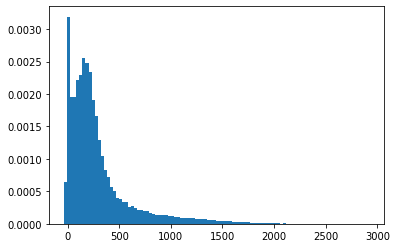

In [231]:
_ = plt.hist(SNs, density=True,bins=100)

In [232]:
def SN_bin(min_SN, SNs, arrays):
    num  = len(arrays)
    indx = np.where(SNs>min_SN)[0]
    arrays_new = [arrays[ii][indx] for ii in range(num)]
    print('new datasize: ', len(indx))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts = SN_bin(1, SNs, [res_fluxes, res_masks, res_inv_vars, redshifts])

new datasize:  51766


In [260]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-3.)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [234]:
mean=np.mean(res_fluxes)
print(mean)

227254.50451851796


In [261]:
BATCH_SIZE   = 32

In [262]:

DATASET_SIZE = len(res_fluxes)
train_size   = int(0.6 * DATASET_SIZE)
test_size    = int(0.2 * DATASET_SIZE)
valid_size   = int(0.2 * DATASET_SIZE)

In [264]:
train_data   = np.expand_dims(res_fluxes[:train_size],-1)/mean
valid_data   = np.expand_dims(res_fluxes[train_size:train_size+valid_size],-1)/mean
train_mask   = np.expand_dims(res_masks[:train_size],-1)
valid_mask   = np.expand_dims(res_masks[train_size:train_size+valid_size],-1)
train_noise  = np.expand_dims(res_inv_vars[:train_size],-1)*mean**2
valid_noise  = np.expand_dims(res_inv_vars[train_size:train_size+valid_size],-1)*mean**2
train_params = np.asarray(redshifts, dtype=np.float32)[:train_size]
valid_params = np.asarray(redshifts, dtype=np.float32)[train_size:train_size+valid_size]

In [270]:
BATCH_SIZE   = 512

In [271]:
history = lstm_ae.fit(x=(train_data,train_mask,train_noise, train_params), batch_size=BATCH_SIZE, epochs=30, callbacks=[callback])

Epoch 1/30
61/61 [==============================] - 0s 5ms/step - training_loss: 2.6079
Epoch 2/30
61/61 [==============================] - 0s 6ms/step - training_loss: 2.2687
Epoch 3/30
61/61 [==============================] - 0s 5ms/step - training_loss: 2.2485
Epoch 4/30
61/61 [==============================] - 0s 5ms/step - training_loss: 2.2165
Epoch 5/30
61/61 [==============================] - 0s 5ms/step - training_loss: 2.2281
Epoch 6/30
61/61 [==============================] - 0s 5ms/step - training_loss: 2.2111
Epoch 7/30
61/61 [==============================] - 0s 5ms/step - training_loss: 2.2154
Epoch 8/30
61/61 [==============================] - 0s 5ms/step - training_loss: 2.1615
Epoch 9/30
61/61 [==============================] - 0s 5ms/step - training_loss: 2.2230
Epoch 10/30
61/61 [==============================] - 0s 5ms/step - training_loss: 2.2002
Epoch 11/30
61/61 [==============================] - 0s 5ms/step - training_loss: 2.2216
Epoch 12/30
61/61 [===========

In [272]:
res_valid = lstm_ae.predict((valid_data,valid_mask,valid_noise, valid_params))

In [273]:
def custom_metric(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]
    valid_loss = np.mean(loss[np.where(y_true[1]==1)])
    return valid_loss

In [274]:
custom_metric((valid_data,valid_mask,valid_noise, valid_params),res_valid)

2.0341993302385664

In [275]:
history.history['training_loss']

[2.0298004150390625,
 3.5612399578094482,
 2.4169886112213135,
 2.7109484672546387,
 2.699727773666382,
 2.025594472885132,
 2.095505475997925,
 3.0957677364349365,
 2.8273608684539795,
 2.2184085845947266,
 2.5135316848754883,
 2.028402090072632,
 3.2381908893585205,
 2.293266773223877,
 2.160823106765747,
 3.488909959793091,
 2.0381810665130615,
 2.225351333618164,
 2.76387619972229,
 2.51330304145813,
 1.9920597076416016,
 2.0884177684783936,
 2.037017583847046,
 1.9456404447555542,
 2.3640804290771484,
 3.065037250518799,
 3.0094428062438965,
 2.057788610458374,
 2.8599085807800293,
 2.8762576580047607]

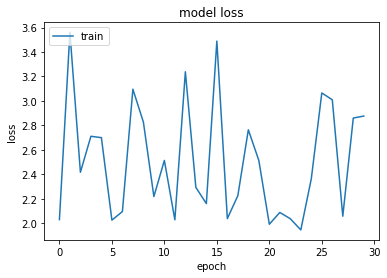

In [276]:
plt.plot(history.history['training_loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [277]:
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(curr_layer)
        new_model.add(curr_layer)
    return new_model

In [278]:
encoder = extract_layers(lstm_ae,1,14)

decoder = extract_layers(lstm_ae,14,26)

In [279]:
encoder.build((None,fixed_num_bins))
decoder.build((None,latent_dim))

In [280]:
encoder.summary()
decoder.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 1000)              0         
_________________________________________________________________
dense_110 (Dense)            (None, 512)               512512    
_________________________________________________________________
batch_normalization_88 (Batc (None, 512)               2048      
_________________________________________________________________
dense_111 (Dense)            (None, 128)               65664     
_________________________________________________________________
batch_normalization_89 (Batc (None, 128)               512       
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 64)               

In [281]:
encoded_valid = encoder.predict(valid_data)
encoded_train = encoder.predict(train_data)

In [282]:
decoded_valid = decoder.predict(encoded_valid)
decoded_train = decoder.predict(encoded_train)

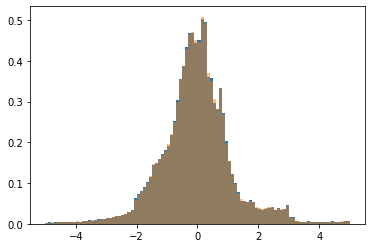

In [283]:
_=plt.hist(encoded_valid.flatten(),bins=100,density=True, range=(-5,5))
_=plt.hist(encoded_train.flatten(),bins=100,density=True, range=(-5,5), alpha=0.5)

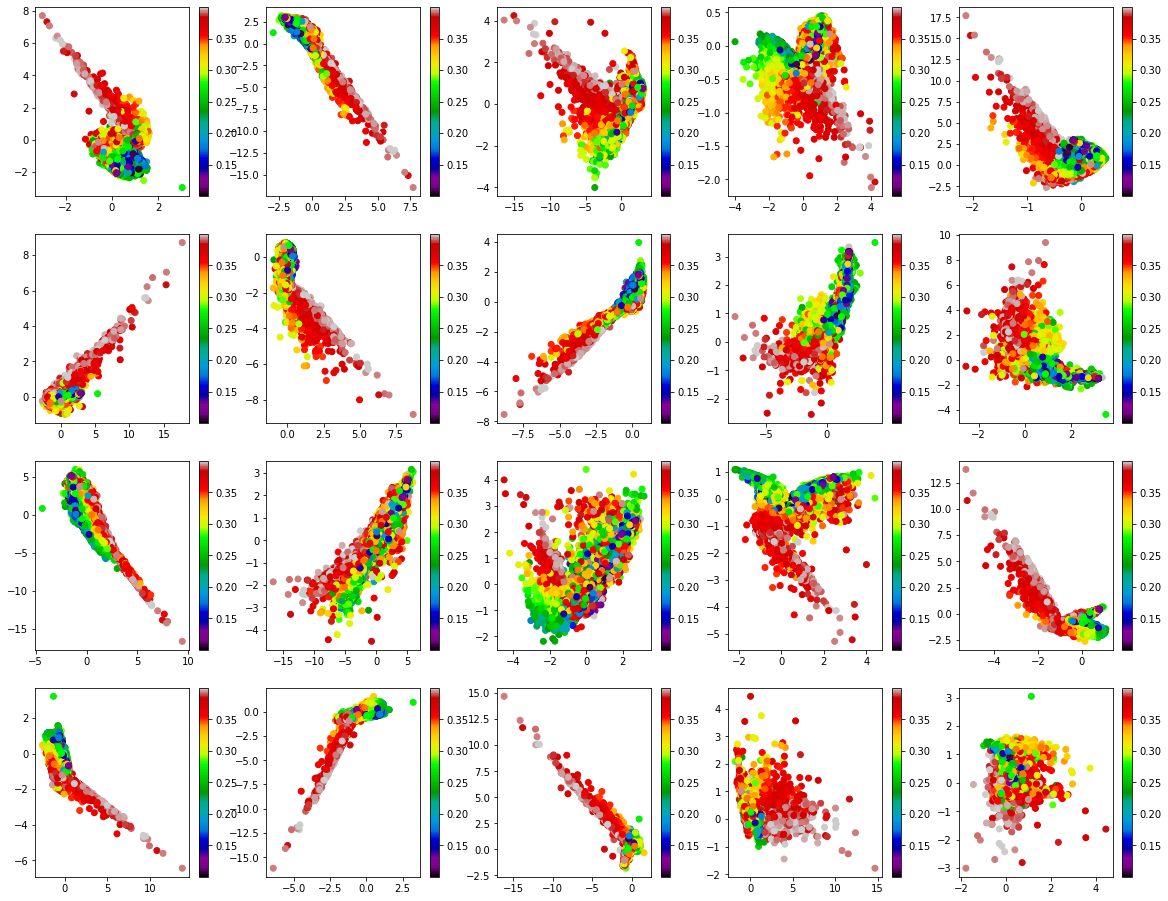

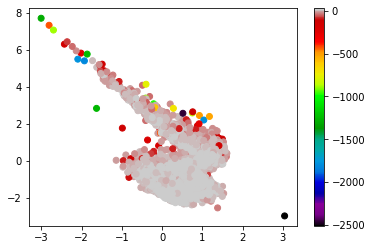

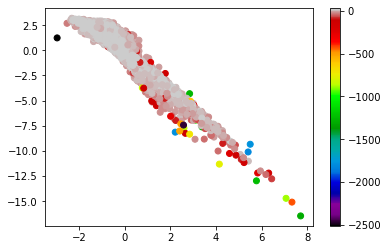

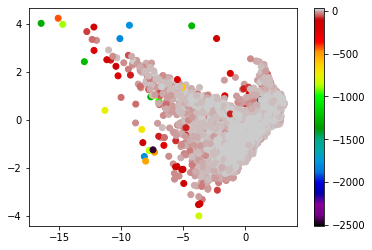

In [333]:
fig, ax = plt.subplots(4,5, figsize=(20,16))
ax=ax.flatten()
for ii in range(20):
    jj= (ii+1)%20
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid_params, cmap='nipy_spectral')
    plt.colorbar(im, ax=ax[ii])
plt.show()
    
for ii in range(3):
    plt.scatter(encoded_valid[:,ii],encoded_valid[:,ii+1],c=logps, cmap='nipy_spectral')
    plt.colorbar()
    plt.show()

['default', 'classic', 'Solarize_Light2', '_classic_test_patch', 'bmh', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


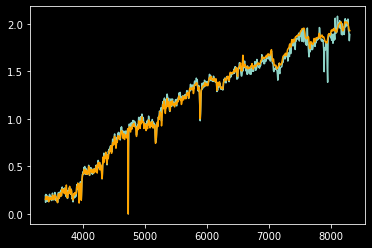

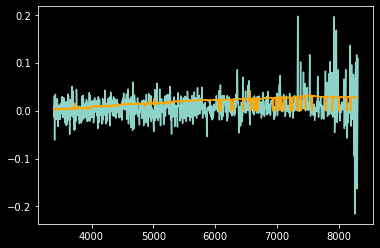

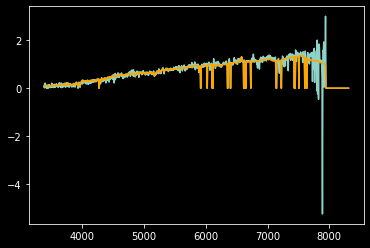

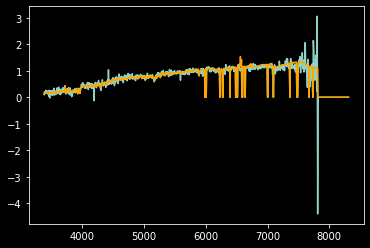

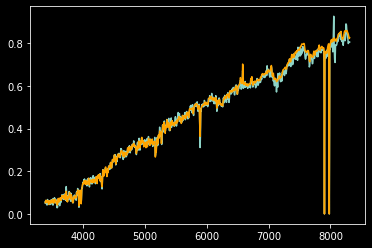

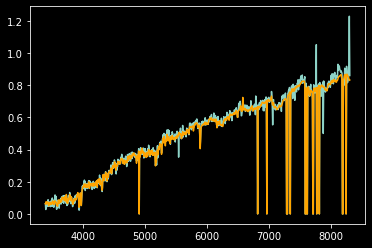

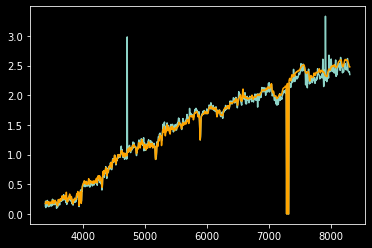

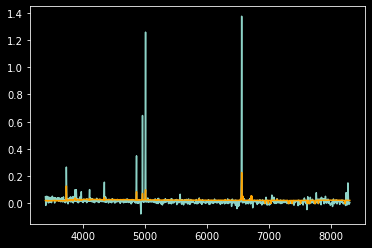

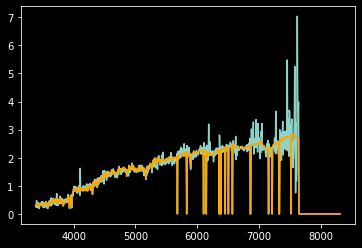

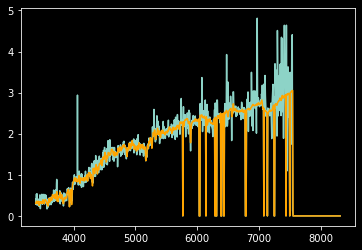

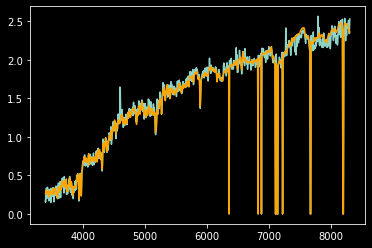

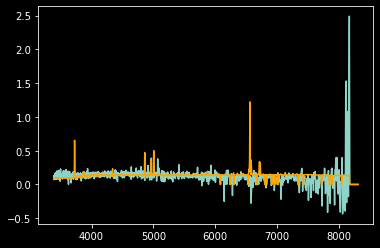

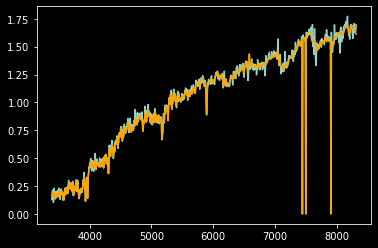

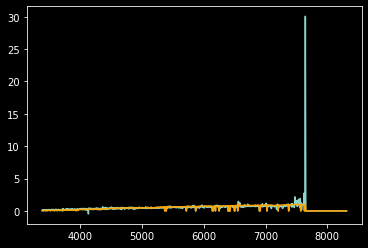

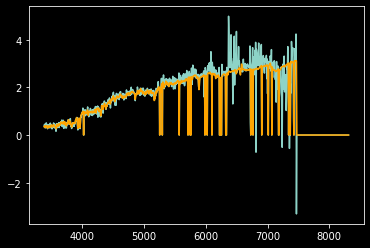

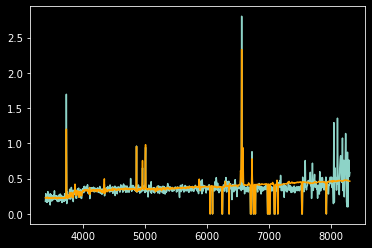

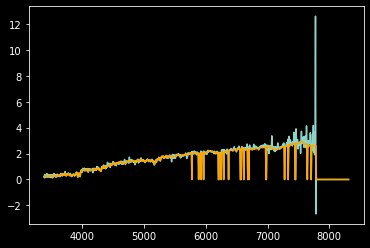

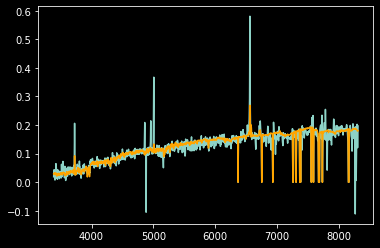

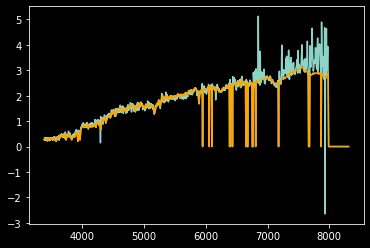

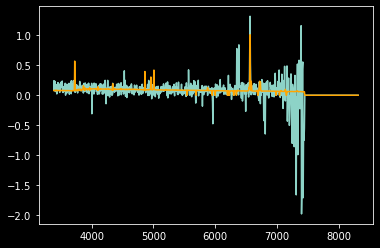

In [284]:

style_list = ['default', 'classic'] + sorted(
    style for style in plt.style.available if style != 'classic')
print(style_list)
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            #fig = plot_figure(style_label=style_label)
            for ii in np.arange(20):
                plt.plot(new_wl[:-1], np.squeeze(valid_data)[ii]*np.squeeze(valid_mask)[ii], )
                plt.plot(new_wl[:-1], np.squeeze(decoded_valid)[ii]*np.squeeze(valid_mask)[ii], color='orange')
                plt.show()

In [285]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

params = {'bandwidth': np.logspace(-2, 1, 25)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(encoded_train[:15000])

GridSearchCV(estimator=KernelDensity(),
             param_grid={'bandwidth': array([ 0.01      ,  0.01333521,  0.01778279,  0.02371374,  0.03162278,
        0.04216965,  0.05623413,  0.07498942,  0.1       ,  0.13335214,
        0.17782794,  0.23713737,  0.31622777,  0.4216965 ,  0.56234133,
        0.74989421,  1.        ,  1.33352143,  1.77827941,  2.37137371,
        3.16227766,  4.21696503,  5.62341325,  7.49894209, 10.        ])})

In [286]:
kde   = grid.best_estimator_

In [287]:
logps = kde.score_samples(encoded_valid)

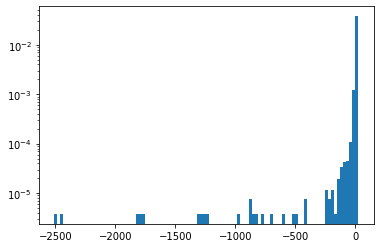

In [288]:
_ = plt.hist(logps, bins=100, density=True, log=True)

In [290]:
indices = np.argsort(logps)

In [341]:
mask_frac = np.sum(valid_mask, axis=(1,2))/1000

Text(0, 0.5, 'logp')

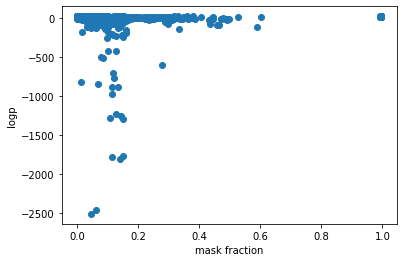

In [346]:
plt.scatter(1-mask_frac, logps)
plt.xlabel('mask fraction')
plt.ylabel('logp')

Text(0, 0.5, 'redshift')

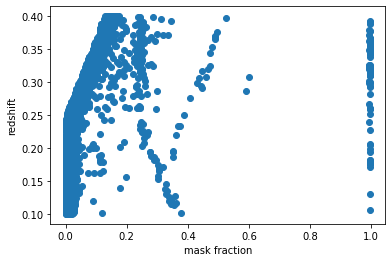

In [347]:
plt.scatter(1-mask_frac, valid_params)
plt.xlabel('mask fraction')
plt.ylabel('redshift')

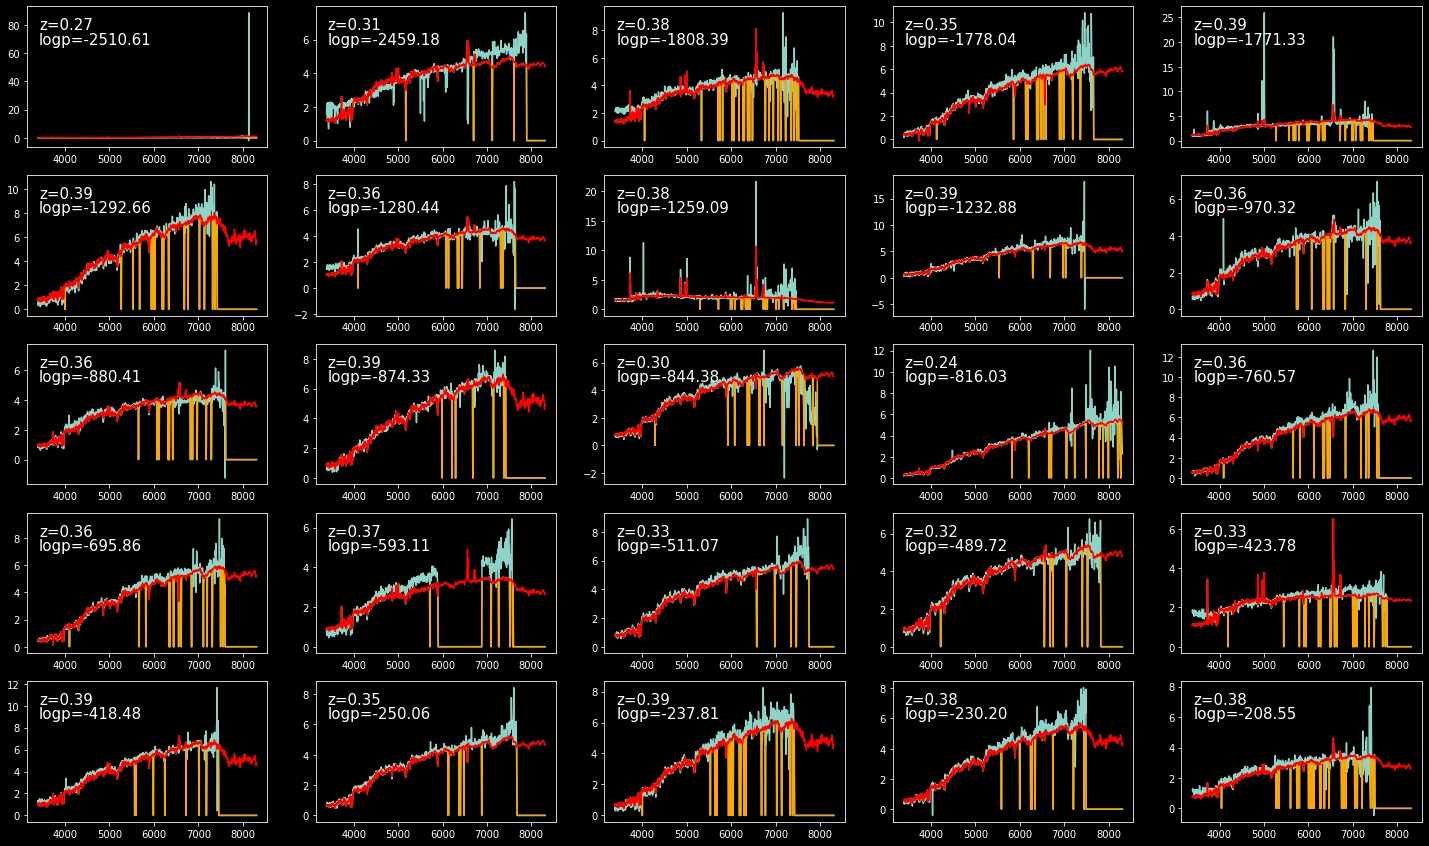

In [334]:


style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(indices[0:25]):
                ax[nn].plot(new_wl[:-1], np.squeeze(valid_data)[ii]*np.squeeze(valid_mask)[ii], )
                ax[nn].plot(new_wl[:-1], np.squeeze(decoded_valid)[ii]*np.squeeze(valid_mask)[ii], color='orange')
                ax[nn].plot(new_wl[:-1], np.squeeze(decoded_valid)[ii], color='red')
                ax[nn].text(0.05, 0.92, r'z=%.2f'%valid_params[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'logp=%.2f'%logps[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)

plt.show()
#                 plt.plot(new_wl[:-1], np.squeeze(valid_data)[np.where(valid_params<0.6)][ii]*np.squeeze(valid_mask)[np.where(valid_params<0.6)][ii], )
#                 plt.show()

In [209]:
# encoded.shape

In [210]:
# decoder = extract_layers(lstm_ae, 18, -1)
# print(encoded.shape)

In [211]:
# decoder.predict(encoded).shape

In [212]:
    
plt.plot(np.mean((train_data[:512]-np.squeeze(recon_train[:512]))**2,axis=0))

ValueError: operands could not be broadcast together with shapes (512,1000,1) (512,1000) 

In [ ]:
plt.plot(np.std((valid_data[:512]-np.squeeze(recon_train[:512]))**2*np.squeeze(valid_noise)[:512]*np.asarray(masks)[:512],axis=0))

In [ ]:
plt.plot(np.std(np.squeeze(recon_train[:512])*np.asarray(masks)[:512],axis=0))

In [ ]:
plt.plot(np.std(np.squeeze(data[:512])*np.asarray(masks)[:512],axis=0))

In [ ]:

for ii in range(20):
    plt.plot(new_wl,data[ii]*masks[ii],label='noisy,masked truth')
    #errs = np.zeros(npix_max, np.int32)
    #errs[np.where(train[0][2][ii].numpy()!=0)[0]] = np.sqrt(1./(train[0][2][ii].numpy()[np.where(train[0][2][ii].numpy()!=0)]))
    plt.errorbar(new_wl,recon_train[ii]*masks[ii])#,yerr=np.squeeze(np.sqrt(1/train[0][3][ii])),label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
    plt.ylim(-0.1,0.1)
    #plt.xlim(4000,5000)
    plt.legend()
    plt.show()
#     plt.plot(np.arange(dim)[600:700],train[0][0][ii][600:700],label='noisy,masked truth')
#     plt.errorbar(np.arange(dim)[600:700],recon_train[ii][600:700],label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
#     plt.legend()
#     plt.show()

for ii in range(20):
    plt.plot(new_wl,(data[ii]-recon_train[ii])**2*noise_train[ii]*masks[ii])
    #errs = np.zeros(npix_max, np.int32)
    #errs[np.where(train[0][2][ii].numpy()!=0)[0]] = np.sqrt(1./(train[0][2][ii].numpy()[np.where(train[0][2][ii].numpy()!=0)]))
    #plt.errorbar(new_wl,*masks[ii])#,yerr=np.squeeze(np.sqrt(1/train[0][3][ii])),label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
    #plt.ylim(-0.1,0.1)
    #plt.xlim(4000,5000)
    plt.legend()
    plt.show()


In [ ]:
for test in test_dataset.take(1):
    for ii in range(20):
        plt.plot(test[0][0][ii],label='noisy,masked truth')
        errs = np.squeeze(np.sqrt(1/test[0][3][ii]))
        print(recon_test[ii].shape, errs.shape)
        plt.errorbar(np.arange(dim),np.squeeze(recon_test[ii]),yerr=errs,label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
        plt.legend()
        plt.show()